In [1]:
from typing import List, Dict
import torch

import sys 
sys.path.append(".")
sys.path.append("..")

from pipeline_attend_and_excite import AttendAndExcitePipeline
from config import RunConfig
from run import run_on_prompt, get_indices_to_alter
from utils import vis_utils
from utils.ptp_utils import AttentionStore

%load_ext autoreload 
%autoreload 2

# Load Model Weights (may take a few minutes)

In [2]:
NUM_DIFFUSION_STEPS = 4
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
safety_checker = StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="safety_checker")
stable = AttendAndExcitePipeline.from_pretrained("SimianLuo/LCM_Dreamshaper_v7",safety_checker=safety_checker).to(device)
tokenizer = stable.tokenizer
#stable.scheduler.steps_offset = 1

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You have passed a non-standard module StableDiffusionSafetyChecker(
  (vision_model): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(257, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0): CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
       

# Pipeline Wrapper

In [3]:
# configurable parameters (see RunConfig for all parameters)
# scale factor- intensity of shift by gradient
# thresholds- a dictionary for iterative refinement mapping the iteration number to the attention threshold
# max_iter_to_alter- maximal inference timestep to apply Attend-and-Excite
def run_and_display(prompts: List[str],
                    controller: AttentionStore,
                    indices_to_alter: List[int],
                    generator: torch.Generator,
                    run_standard_sd: bool = False,
                    scale_factor: int = 20,
                    thresholds: Dict[int, float] = {0: 0.05, 10: 0.5, 20: 0.8},
                    max_iter_to_alter: int = 25,
                    display_output: bool = False):
    config = RunConfig(prompt=prompts[0],
                       run_standard_sd=run_standard_sd,
                       scale_factor=scale_factor,
                       thresholds=thresholds,
                       max_iter_to_alter=max_iter_to_alter)
    image = run_on_prompt(model=stable,
                          prompt=prompts,
                          controller=controller,
                          token_indices=indices_to_alter,
                          seed=generator,
                          config=config)
    if display_output:
        display(image)
    return image

# Show Cross-Attention Per Strengthened Token

## Define your seeds, prompt and the indices to strengthen

In [12]:
prompt = 'A playful kitten chasing a butterfly in a wildflower meadow'
seeds = [62]

In [13]:
token_indices = get_indices_to_alter(stable, prompt)

{1: 'a',
 2: 'playful',
 3: 'kitten',
 4: 'chasing',
 5: 'a',
 6: 'butterfly',
 7: 'in',
 8: 'a',
 9: 'wildflower',
 10: 'meadow'}


Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5):  3,6,10


Altering tokens: ['kitten', 'butterfly', 'meadow']


## Stable Diffusion

  0%|          | 0/4 [00:00<?, ?it/s]

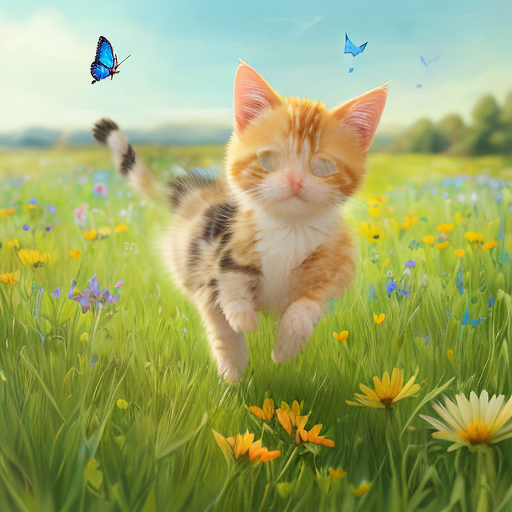

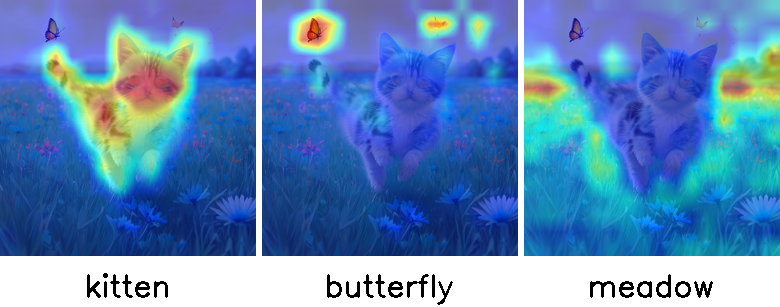

In [14]:
for seed in seeds:
    g = torch.Generator('cuda').manual_seed(seed)
    prompts = [prompt]
    controller = AttentionStore()
    image = run_and_display(prompts=prompts,
                            controller=controller,
                            indices_to_alter=token_indices,
                            generator=g,
                            run_standard_sd=True,
                            display_output=True)
    vis_utils.show_cross_attention(attention_store=controller,
                                   prompt=prompt,
                                   tokenizer=tokenizer,
                                   res=16,
                                   from_where=("up", "down", "mid"),
                                   indices_to_alter=token_indices,
                                   orig_image=image)

## Attend-and-Excite

  0%|          | 0/4 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.1047
Iteration 1 | Loss: 0.0986
Iteration 2 | Loss: 0.3477
Iteration 3 | Loss: 0.4697


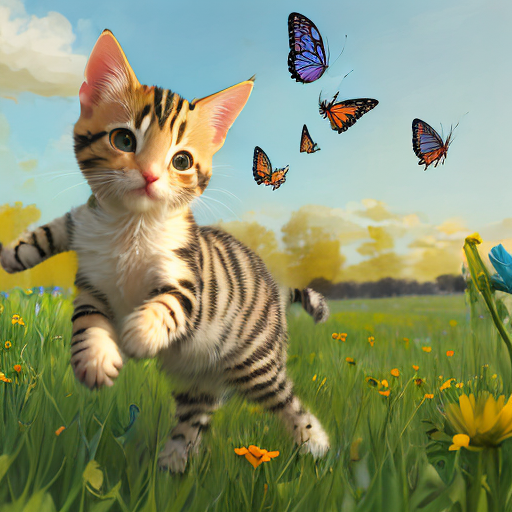

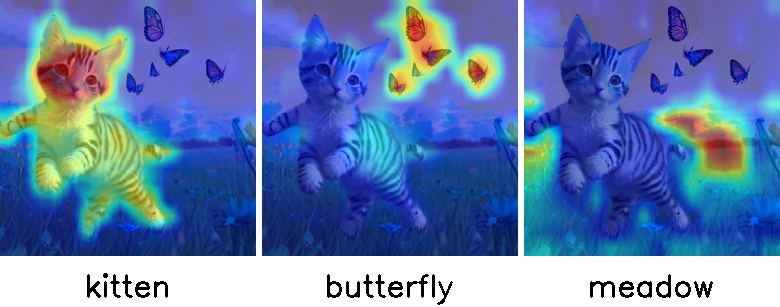

In [15]:
for seed in seeds:
    g = torch.Generator('cuda').manual_seed(seed)
    prompts = [prompt]
    controller = AttentionStore()
    image = run_and_display(prompts=prompts,
                            controller=controller,
                            indices_to_alter=token_indices,
                            generator=g,
                            run_standard_sd=False,
                            display_output=True)
    vis_utils.show_cross_attention(attention_store=controller,
                                   prompt=prompt,
                                   tokenizer=tokenizer,
                                   res=16,
                                   from_where=("up", "down", "mid"),
                                   indices_to_alter=token_indices,
                                   orig_image=image)

## 